In [14]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import utils_plots as ut

In [15]:
perc = 75
predictors_type = 'original+detrend' # 'original', 'deseason', 'detrend', 'original+detrend' (original predictions, detrended for timeseries comparison)
# Set parameters for run name
if predictors_type == 'original' or predictors_type == 'original+detrend':
    n_clusters_dict = {'NEP': 7, 'NWP': 10, 'NA': 6, 'NI': 7, 'SI': 6, 'SP': 9}
    str_pt = 'nc'
elif predictors_type == 'deseason':
    n_clusters_dict = {'NEP': 6, 'NWP': 10, 'NA': 10, 'NI': 8, 'SI': 8, 'SP': 9}
    str_pt = 'DSnc'
elif predictors_type == 'detrend':
    n_clusters_dict = {'NEP': 12, 'NWP': 10, 'NA': 12, 'NI': 11, 'SI': 7, 'SP': 10}
    str_pt = 'DTnc'

In [16]:
# Set years range and number of folds
years = np.arange(1980, 2022, 1) # from 1980 to 2021 included
n_folds = 3
# Set directories and file paths, then load file containing predictors and target
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
fs_dir = os.path.join(project_dir, 'tcg_fsM')

In [17]:
basins = ['NEP', 'NWP', 'NA', 'NI', 'SI', 'SP']
for b, basin in enumerate(basins):
    # Set the predictors data and the target
    n_clusters = n_clusters_dict[basin]
    run_name = f'selfeat{perc}_top20_{str_pt}{n_clusters}_nv8_nd9'
    if predictors_type == 'deseason':
        cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    elif predictors_type == 'detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
    elif predictors_type == 'original+detrend':
        cluster_data = f'{basin}_{n_clusters}clusters_detrend'
    else:
        cluster_data = f'{basin}_{n_clusters}clusters'
    cluster_data_dir = os.path.join(fs_dir, 'data', cluster_data)
    # Get the run info and data
    Y_pred, Y_pred_noFS, _, _, mlps, mlps_noFS, _ = ut.runs_info(basin, run_name, project_dir, years)
    # Convert list of dataframes to a single dataframe
    Y_pred_df = pd.concat(Y_pred)
    Y_pred_noFS_df = pd.concat(Y_pred_noFS)
    # If predictions with original data are negative, set them to 0
    if predictors_type == 'original' or predictors_type == 'original+detrend':
        Y_pred_df[Y_pred_df < 0] = 0.0
        Y_pred_noFS_df[Y_pred_noFS_df < 0] = 0.0
    # Sum the predictions for each basin
    if b == 0:
        Y_pred_df_glb = Y_pred_df
        Y_pred_noFS_df_glb = Y_pred_noFS_df
    else:
        Y_pred_df_glb += Y_pred_df
        Y_pred_noFS_df_glb += Y_pred_noFS_df
# Get the observations on the global scale
resolution = '2.5x2.5'
target_path = os.path.join(project_dir, 'data', 'IBTrACS', resolution, 'TCG', f'TCG_{resolution}')
tcg_ds = xr.concat([xr.open_dataset(target_path + f'_{year}.nc') for year in years], dim='time')
date_range = pd.date_range(start=f'{years[0]}-01-01', end=f'{years[-1]}-12-01', freq='MS')
target_df = pd.DataFrame(index=date_range)
target_df['tcg'] = tcg_ds.tcg.sum(dim=['latitude', 'longitude']).values.astype(int)
# gpis
gpis_file = f'GLB_2.5x2.5_gpis_time_series.csv'
gpis_path = os.path.join(fs_dir, 'data', gpis_file)
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpis_df = gpis_df.loc[gpis_df.index.year.isin(years)]
# If predictions for original + detrend remove trend
if predictors_type == 'original+detrend':
    decomp_pred_FS = STL(Y_pred_df_glb['tcg']).fit()
    decomp_pred_noFS = STL(Y_pred_noFS_df_glb['tcg']).fit()
    Y_pred_df_glb['tcg'] = Y_pred_df_glb['tcg'] - decomp_pred_FS.trend
    Y_pred_noFS_df_glb['tcg'] = Y_pred_noFS_df_glb['tcg'] - decomp_pred_noFS.trend

**Time series Trajectories**

In [18]:
# Annual data 
Y_pred_df_glb_annual = Y_pred_df_glb.groupby(Y_pred_df_glb.index.year).sum()
Y_pred_noFS_df_glb_annual = Y_pred_noFS_df_glb.groupby(Y_pred_noFS_df_glb.index.year).sum()
# GPIs time series 
engpi_TS = gpis_df['engpi']
ogpi_TS = gpis_df['ogpi']
decomp_engpi = STL(engpi_TS).fit()
decomp_ogpi = STL(ogpi_TS).fit()
decomp_target = STL(target_df['tcg']).fit()
if predictors_type == 'deseason':
    engpi = engpi_TS - decomp_engpi.seasonal
    ogpi = ogpi_TS - decomp_ogpi.seasonal
    target = target_df['tcg'] - decomp_target.seasonal
elif predictors_type == 'detrend' or predictors_type == 'original+detrend':
    engpi = engpi_TS - decomp_engpi.trend
    ogpi = ogpi_TS - decomp_ogpi.trend
    target = target_df['tcg'] - decomp_target.trend
else:
    engpi = engpi_TS
    ogpi = ogpi_TS
    target = target_df['tcg']
# Annual data of the GPIs
target_annual = target.groupby(target.index.year).sum()
engpi_annual = engpi.groupby(engpi.index.year).sum()
ogpi_annual = ogpi.groupby(ogpi.index.year).sum()
# Seasonal data aggregation
if predictors_type == 'original+detrend':
    # If using original+detrend, add the trend back to the time series for better plot
    target_seasonal = target_df['tcg'].copy()
    target_seasonal = target_seasonal.groupby(target_seasonal.index.month).mean()
    Y_pred_df_glb_seasonal = Y_pred_df_glb.copy()
    Y_pred_df_glb_seasonal['tcg'] = Y_pred_df_glb['tcg'] + decomp_pred_FS.trend
    Y_pred_df_glb_seasonal = Y_pred_df_glb_seasonal.groupby(Y_pred_df_glb_seasonal.index.month).mean()
    Y_pred_noFS_df_glb_seasonal = Y_pred_noFS_df_glb.copy()
    Y_pred_noFS_df_glb_seasonal['tcg'] = Y_pred_noFS_df_glb['tcg'] + decomp_pred_noFS.trend
    Y_pred_noFS_df_glb_seasonal = Y_pred_noFS_df_glb_seasonal.groupby(Y_pred_noFS_df_glb_seasonal.index.month).mean()
    engpi_seasonal = engpi_TS.copy()
    engpi_seasonal = engpi_seasonal.groupby(engpi_seasonal.index.month).mean()
    ogpi_seasonal = ogpi_TS.copy()
    ogpi_seasonal = ogpi_seasonal.groupby(ogpi_seasonal.index.month).mean()
else:
    target_seasonal = target_df['tcg'].groupby(target_df.index.month).mean()
    Y_pred_df_glb_seasonal = Y_pred_df_glb['tcg'].groupby(Y_pred_df_glb.index.month).mean()
    Y_pred_noFS_df_glb_seasonal = Y_pred_noFS_df_glb['tcg'].groupby(Y_pred_noFS_df_glb.index.month).mean()
    engpi_seasonal = engpi_TS.groupby(engpi_TS.index.month).mean()
    ogpi_seasonal = ogpi_TS.groupby(ogpi_TS.index.month).mean()
# Compute the correlation coefficient and the MSE between the predictions and the test values
# Monthly 
r, p_value = pearsonr(target, Y_pred_df_glb['tcg'])
r_noFS, p_value_noFS = pearsonr(target, Y_pred_noFS_df_glb['tcg'])
r_engpi, p_value_engpi = pearsonr(target, engpi)
r_ogpi, p_value_ogpi = pearsonr(target, ogpi)
mse = mean_squared_error(target, Y_pred_df_glb['tcg'])
mse_noFS = mean_squared_error(target, Y_pred_noFS_df_glb['tcg'])
mse_engpi = mean_squared_error(target, engpi)
mse_ogpi = mean_squared_error(target, ogpi)
# Annual 
rY, p_valueY = pearsonr(target_annual, Y_pred_df_glb_annual['tcg'])
rY_noFS, p_value_noFSY = pearsonr(target_annual, Y_pred_noFS_df_glb_annual['tcg'])
rY_engpi, p_value_engpiY = pearsonr(target_annual, engpi_annual)
rY_ogpi, p_value_ogpiY = pearsonr(target_annual, ogpi_annual)
mseY = mean_squared_error(target_annual, Y_pred_df_glb_annual['tcg'])
mseY_noFS = mean_squared_error(target_annual, Y_pred_noFS_df_glb_annual['tcg'])
mseY_engpi = mean_squared_error(target_annual, engpi_annual)
mseY_ogpi = mean_squared_error(target_annual, ogpi_annual)
# Seasonal
rS, p_valueS = pearsonr(target_seasonal, Y_pred_df_glb_seasonal['tcg'])
rS_noFS, p_value_noFS_S = pearsonr(target_seasonal, Y_pred_noFS_df_glb_seasonal['tcg'])
rS_engpi, p_value_engpi_S = pearsonr(target_seasonal, engpi_seasonal)
rS_ogpi, p_value_ogpi_S = pearsonr(target_seasonal, ogpi_seasonal)
mseS = mean_squared_error(target_seasonal, Y_pred_df_glb_seasonal['tcg'])
mseS_noFS = mean_squared_error(target_seasonal, Y_pred_noFS_df_glb_seasonal['tcg'])
mseS_engpi = mean_squared_error(target_seasonal, engpi_seasonal)
mseS_ogpi = mean_squared_error(target_seasonal, ogpi_seasonal)

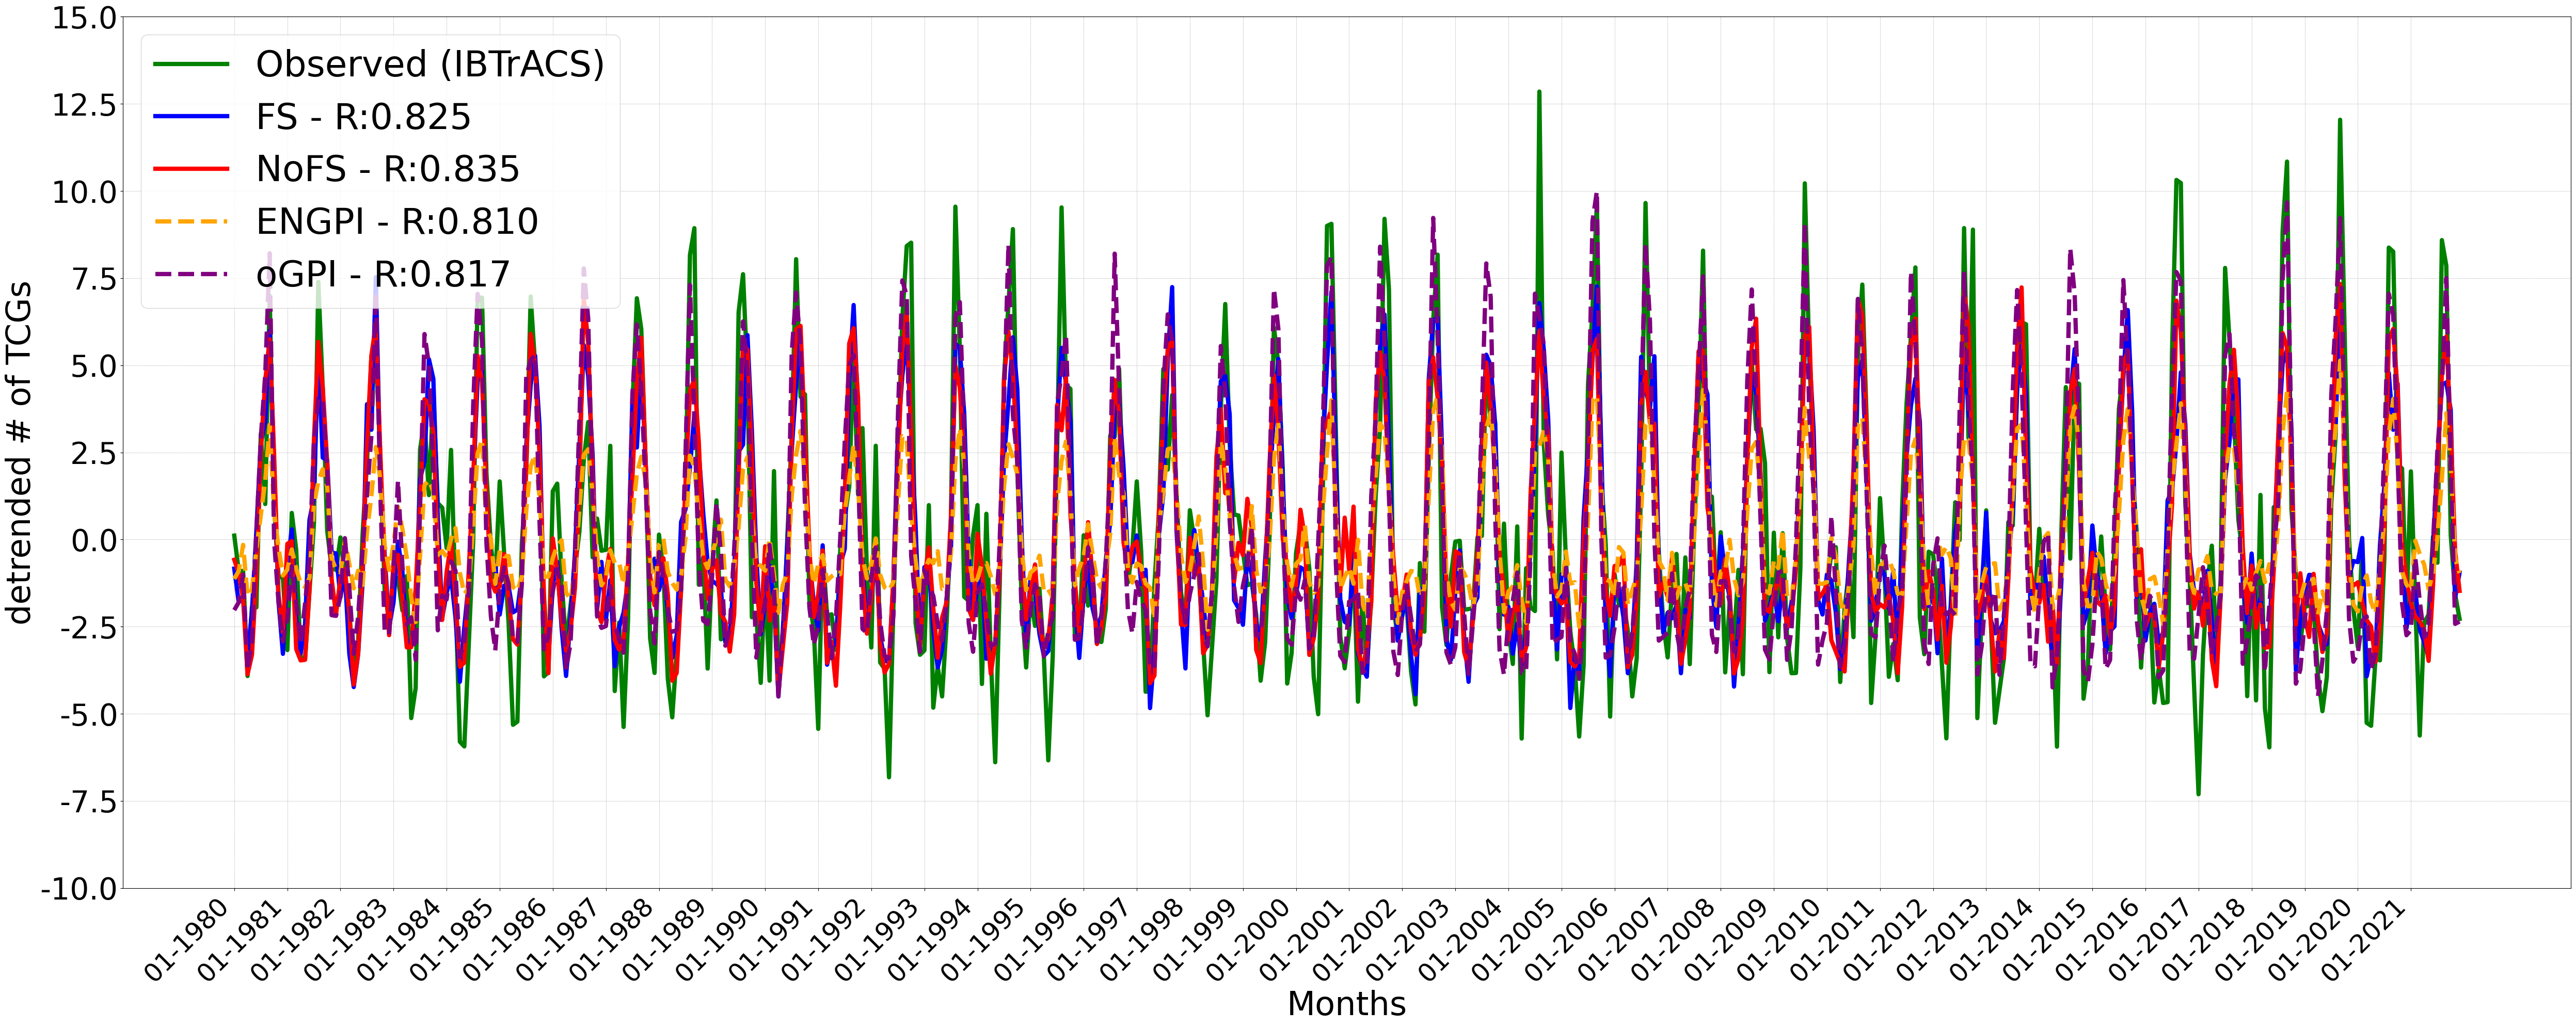

In [19]:
# Plotting the monthly time series 
fig_ts = ut.plot_monthly_time_series(target, Y_pred_df_glb['tcg'], Y_pred_noFS_df_glb['tcg'], engpi, ogpi, r, r_noFS, r_engpi, r_ogpi)
fig_ts.savefig(os.path.join(fs_dir, 'best_model_analysis', 'figures', f'GLB_monthly_time_series.pdf'), format='pdf', dpi=300, bbox_inches='tight')

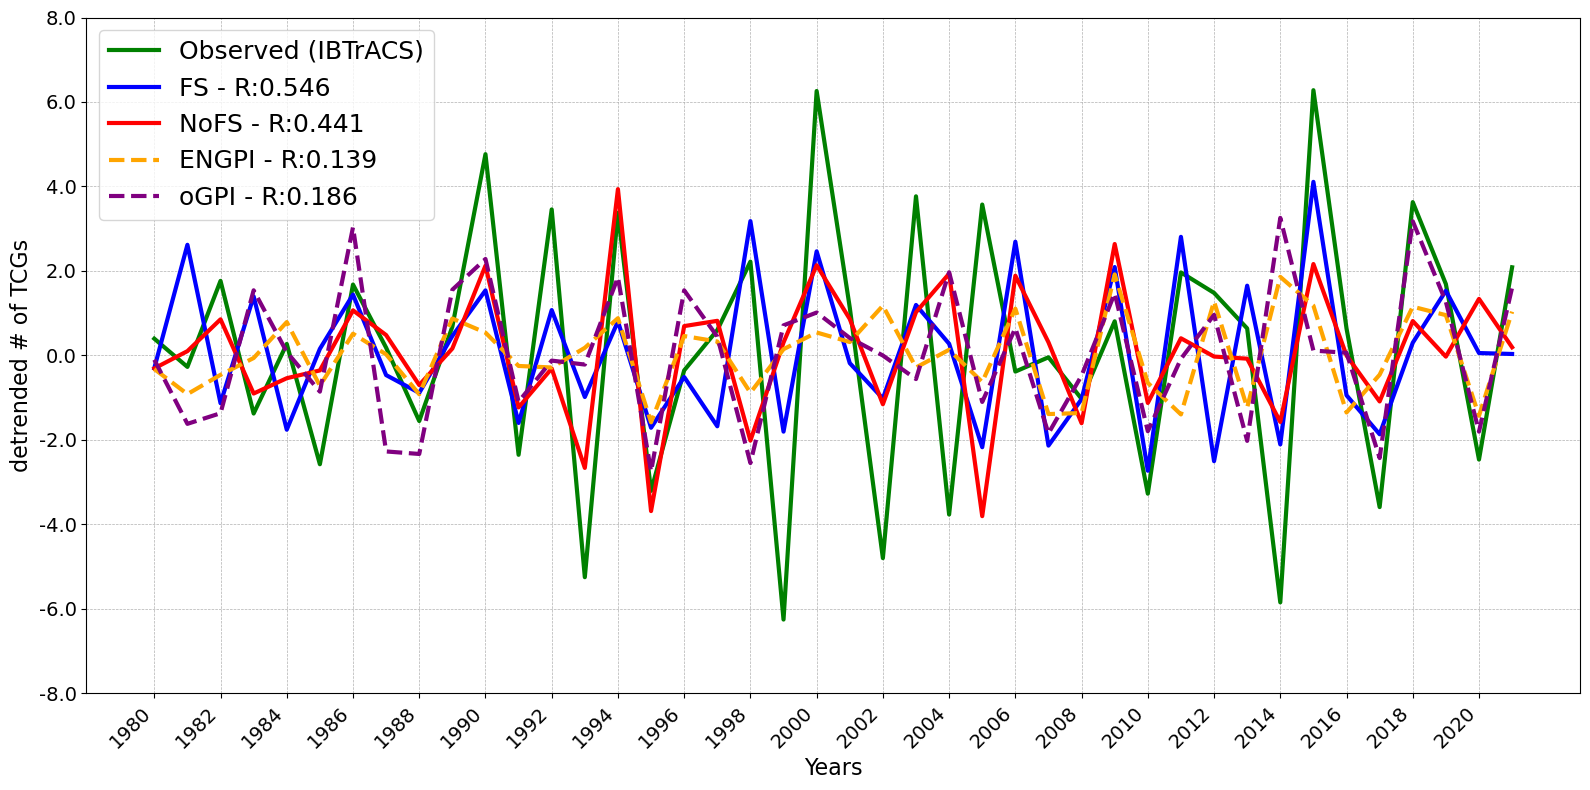

In [20]:
# Plotting the annual time series
fig_annual = ut.plot_annual_time_series(target_annual, Y_pred_df_glb_annual['tcg'], Y_pred_noFS_df_glb_annual['tcg'], engpi_annual, ogpi_annual, rY, rY_noFS, rY_engpi, rY_ogpi)
fig_annual.savefig(os.path.join(fs_dir,'best_model_analysis', 'figures', f'GLB_annual_time_series.pdf'), format='pdf', dpi=300, bbox_inches='tight')

In [21]:
print(f'=== annual mse ===')
print(f'fs: {mseY:.3f}')
print(f'noFS: {mseY_noFS:.3f}')
print(f'engpi: {mseY_engpi:.3f}')
print(f'ogpi: {mseY_ogpi:.3f}')
print(f'=== p values ===')
print(f'fs: {p_valueY:.3f}')
print(f'noFS: {p_value_noFSY:.3f}')
print(f'engpi: {p_value_engpiY:.3f}')
print(f'ogpi: {p_value_ogpiY:.3f}')

=== annual mse ===
fs: 6.494
noFS: 7.498
engpi: 9.349
ogpi: 10.067
=== p values ===
fs: 0.000
noFS: 0.003
engpi: 0.380
ogpi: 0.238


In [22]:
# Meng, Rosenthal & Rubin's Z-test to compare the correlation coefficients statistically
rY_FS_noFS, _ = pearsonr(Y_pred_df_glb_annual['tcg'], Y_pred_noFS_df_glb_annual['tcg'])
z_stat, p_val = ut.meng_test(rY, rY_noFS, rY_FS_noFS, len(target_annual))
print(f'=== Meng, Rosenthal & Rubin\'s Z-test ===')
print(f'Z-statistic: {z_stat:.3f}')
print(f'p-value: {p_val:.3f}')

=== Meng, Rosenthal & Rubin's Z-test ===
Z-statistic: 0.800
p-value: 0.424


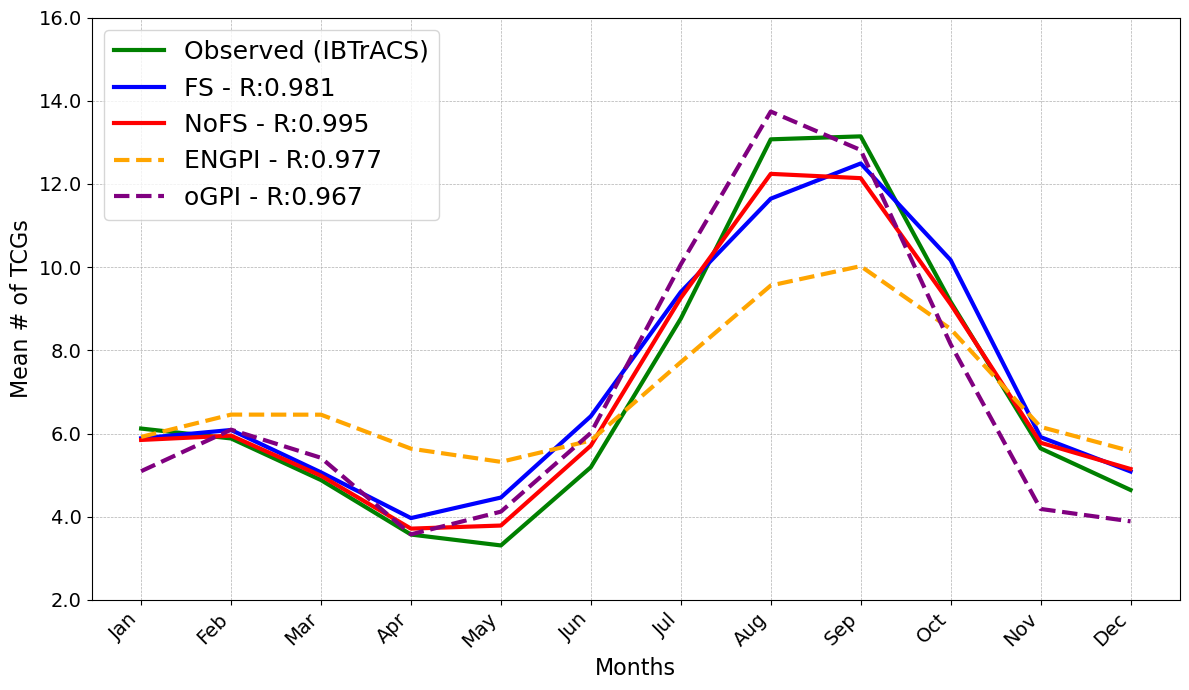

In [23]:
# Plot the seasonal time series
fig_seasonal = ut.plot_seasonal_time_series(target_seasonal, Y_pred_df_glb_seasonal['tcg'], Y_pred_noFS_df_glb_seasonal['tcg'], engpi_seasonal, ogpi_seasonal, rS, rS_noFS, rS_engpi, rS_ogpi)
fig_seasonal.savefig(os.path.join(fs_dir, 'best_model_analysis', 'figures', f'GLB_seasonal_time_series.pdf'), format='pdf', dpi=300, bbox_inches='tight')

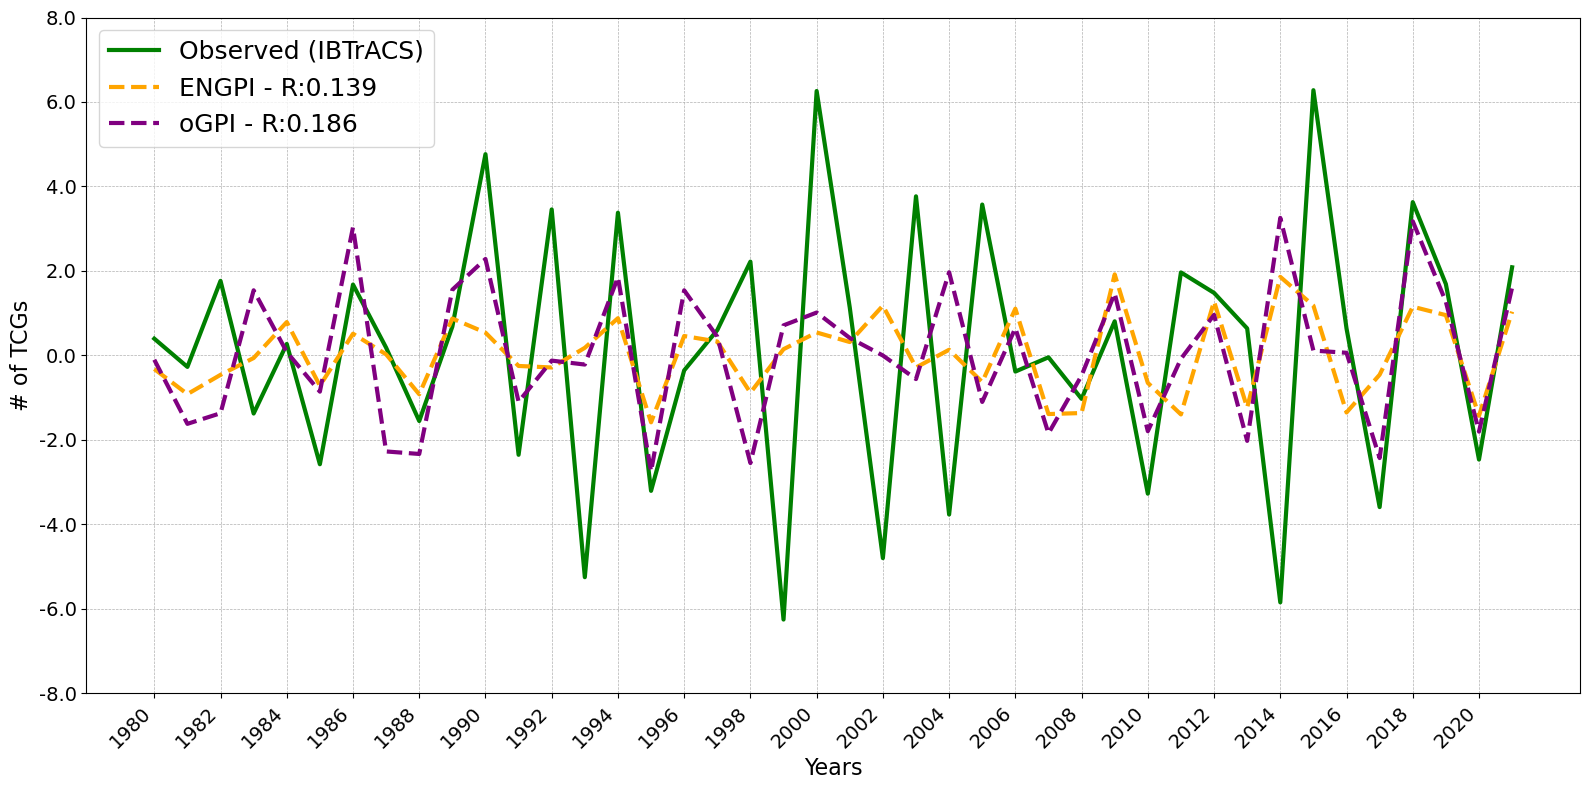

In [24]:
import matplotlib.pyplot as plt

fig_annual = plt.figure(figsize=(16, 8))
axY = fig_annual.add_subplot(111)
# observations
axY.plot(target_annual.index, target_annual, label='Observed (IBTrACS)', color='green', linewidth=3)
# gpis
axY.plot(engpi_annual.index, engpi_annual, label=f'ENGPI - R:{rY_engpi:.3f}', color='orange', linewidth=3, linestyle='--')
axY.plot(ogpi_annual.index, ogpi_annual, label=f'oGPI - R:{rY_ogpi:.3f}', color='purple', linewidth=3, linestyle='--')
# set figure parameters
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(target_annual.index[::2])
axY.set_xticklabels(target_annual.index[::2], rotation=45, fontsize=14, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=14)
axY.set_xlabel('Years', fontsize=16)
axY.set_ylabel('# of TCGs', fontsize=16)
axY.legend(fontsize=18, loc='best')
# Finalize the figure
fig_annual.set_tight_layout(True)
plt.show()

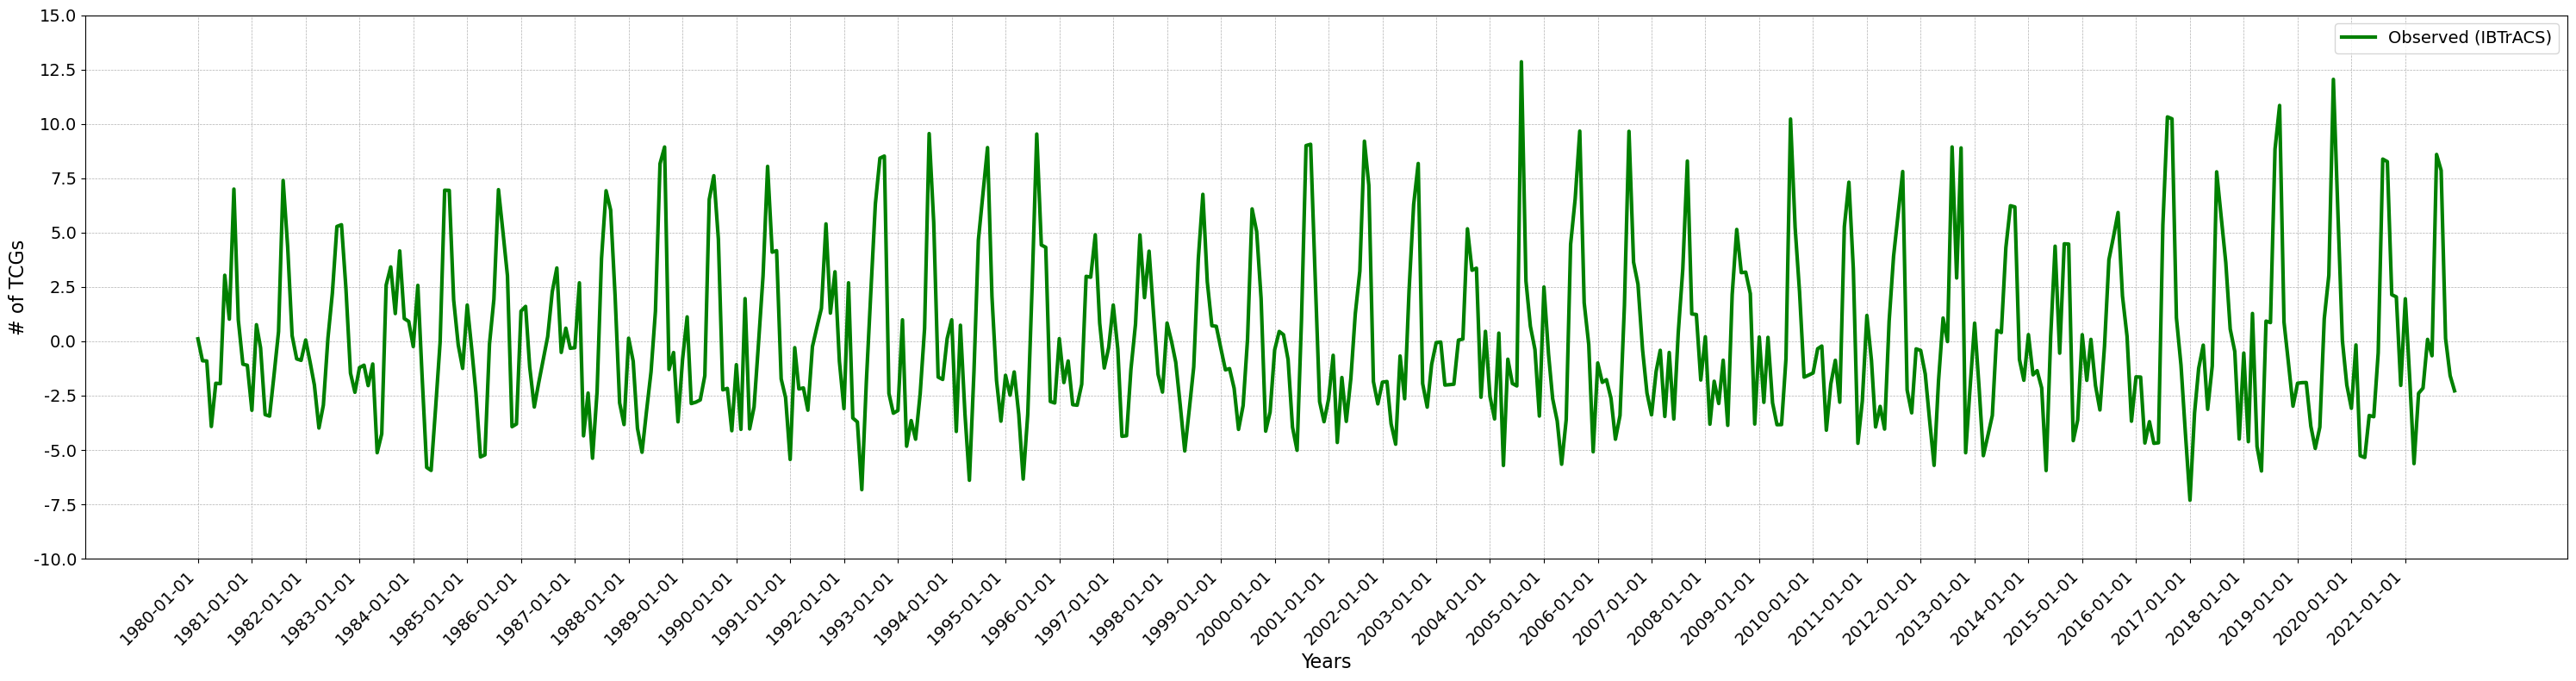

In [25]:
fig_month = plt.figure(figsize=(30, 8))
axY = fig_month.add_subplot(111)
# observations
axY.plot(target.index, target, label='Observed (IBTrACS)', color='green', linewidth=3)
# set figure parameters
axY.grid(True, which='both', linestyle='--', linewidth=0.5)
axY.set_xticks(target.index.date[::12])
axY.set_xticklabels(target.index.date[::12], rotation=45, fontsize=14, ha='right')
axY.set_yticks(axY.get_yticks())
axY.set_yticklabels(axY.get_yticks(), fontsize=14)
axY.set_xlabel('Years', fontsize=16)
axY.set_ylabel('# of TCGs', fontsize=16)
axY.legend(fontsize=14, loc='best')
# Finalize the figure
fig_month.set_tight_layout(True)
plt.show()